# Loading the dataset

In [ ]:
# Import PyDrive and associated libraries
# This only needs to be done once per notebook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# This only needs to be done once per notebook
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download a file based on its file ID.

# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '13U0iA49UMjjSTPrVMkkamqtU9Q2qepUO' # Check your own ID in GDrive
downloaded = drive.CreateFile({'id': file_id})

# Save file in Colab memory
downloaded.GetContentFile('tweet_data.csv')  

# Installing dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style('dark')
from wordcloud import WordCloud


In [ ]:
df = pd.read_csv('tweet_data.csv', lineterminator='\n')
df = df.drop(['Unnamed: 0'],axis=1)

# VADER Sentiment Analysis

In [ ]:
# Performing VADER Sentiment Analysis
import nltk
nltk.download('vader_lexicon') # Download the VADER lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Obtaining NLTK scores
df['VScore'] = df['Clean Text'].apply(lambda x: sia.polarity_scores(x))

# Obtaining NLTK compound score
df['VComp'] = df['VScore'].apply(lambda score_dict: score_dict['compound'])

# Set threshold to define neutral sentiment
neutral_thresh = 0.05

# Categorize scores into the sentiments of positive, neutral or negative
df['Sentiment'] = df['VComp'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
df.head(5)

,Datetime,Text,Username,Like Count,Display Name,Clean Text,VScore,VComp,Sentiment
0,2020-12-01,Union Health Secretary Rajesh Bhushan said the...,ThePrintIndia,6,ThePrintIndia,union health secretary rajesh bhushan said the...,"{'neg': 0.082, 'neu': 0.918, 'pos': 0.0, 'comp...",-0.3612,Negative
1,2020-12-01,First Covid vaccines to be offered to health w...,walk4chang_sue,0,Sue Walker,first covid vaccines to be offered to health w...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
2,2020-12-01,The AP reported that An influential Gov't Pane...,DogginTrump,95,WTFGOP?,the ap reported that an influential govt panel...,"{'neg': 0.0, 'neu': 0.81, 'pos': 0.19, 'compou...",0.7269,Positive
3,2020-12-01,CDC vaccine advisers recommend health care sta...,hazeldfernandez,0,нαzєℓ,cdc vaccine advisers recommend health care sta...,"{'neg': 0.0, 'neu': 0.611, 'pos': 0.389, 'comp...",0.8360,Positive
4,2020-12-01,"CDC panel says health workers, nursing homes w...",MrBig305,0,"Just Me - ALL GODS PAST & PRESENT, ARE IMAGINARY",cdc panel says health workers nursing homes wi...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral


(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.,
        350000., 400000.]), <a list of 9 Text major ticklabel objects>)

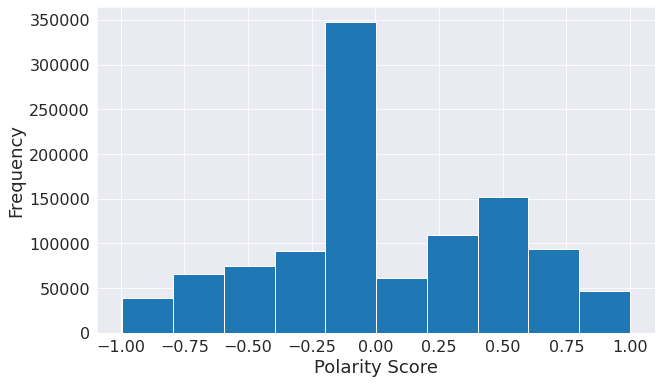

In [ ]:
fig = plt.figure(figsize=(10, 6))
df['VComp'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

**Making wordclouds**

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords_to_add = ['covid', 'via', 'v','a','c','c','i','n','e', 'people', 'get','getting','vaccination', 'amp', 'vaccine', 'covid19', 'covidvaccine']
stop_words.extend(new_stopwords_to_add)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


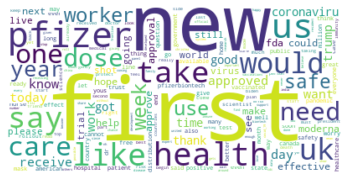

In [ ]:
pos_tweets=df[df["Sentiment"]=="Positive"]
txt=" ".join(tweet for tweet in pos_tweets["Clean Text"])
import re
line = re.sub('vaccine+', "", txt)

wordcloud = WordCloud(collocations = False,
                      background_color = 'white',
                      stopwords=stop_words).generate(line)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

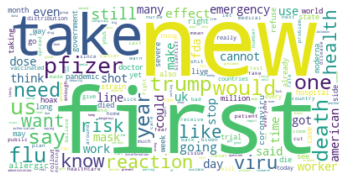

In [ ]:
neg_tweets=df[df["Sentiment"]=="Negative"]
txt=" ".join(tweet.lower() for tweet in neg_tweets["Clean Text"])
line = re.sub('vaccine+', "", txt)
wordcloud = WordCloud(collocations = False,background_color = 'white', stopwords=stop_words).generate(line)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Graphing the people's opinions**

In [ ]:
# Getting the sentiments dataframe
def get_value_counts(col_name):
    count = pd.DataFrame(df[col_name].value_counts())
    percentage = pd.DataFrame(df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df
tb_sentiment_df = get_value_counts('Sentiment')
tb_sentiment_df

,sentiment,counts,percentage
0,Negative,313095,28.97
1,Neutral,316260,29.26
2,Positive,451398,41.77


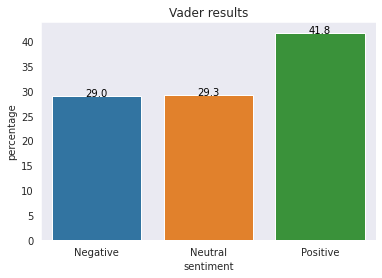

In [ ]:
# Plotting percentage of sentiments
ax = sns.barplot(x="sentiment", y="percentage", data=tb_sentiment_df)
ax.set_title('Vader results')

for index, row in tb_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

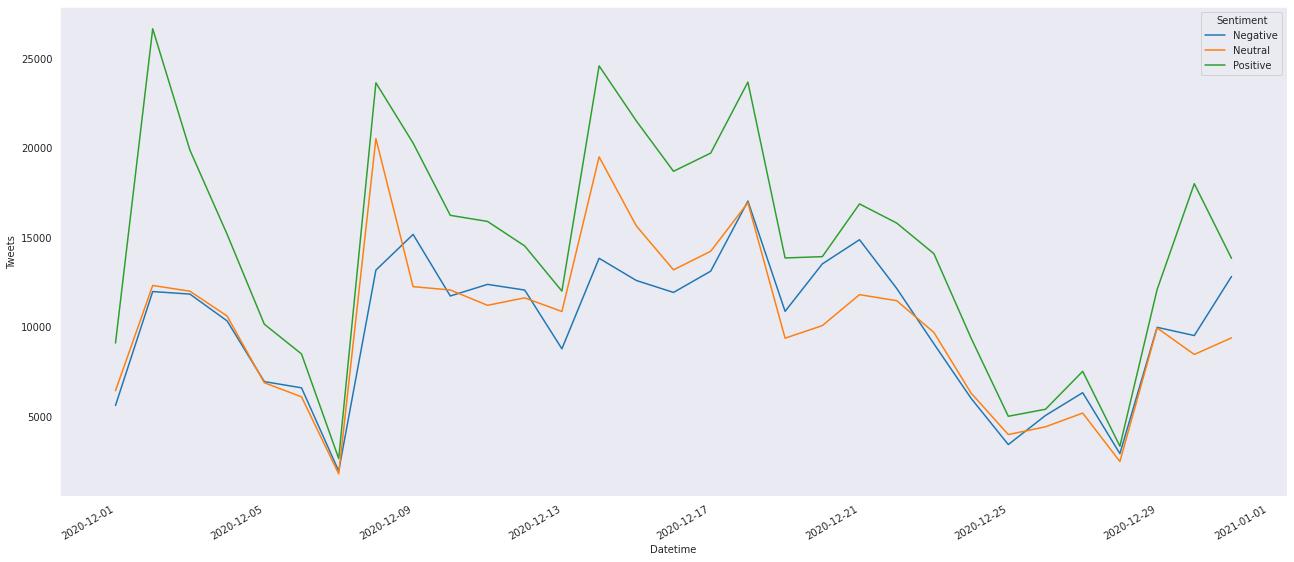

In [ ]:
# Plotting timeseries plot
df["Datetime"] = pd.to_datetime(df.Datetime) 
timeline = df.resample('D', on='Datetime')["Sentiment"].value_counts().unstack(1)
timeline.reset_index(inplace=True)
timeline = timeline.melt("Datetime", var_name='Sentiment',  value_name='Tweets')

plt.figure(figsize=(22,10))
ax = sns.lineplot(x="Datetime", y="Tweets", hue="Sentiment", data=timeline)
ax.figure.autofmt_xdate()

**Checking out top 10 most negative tweets**

In [ ]:
pd.set_option('display.max_colwidth', 400)
df.sort_values(by='VComp', ascending=True)[['Text', 'VComp', 'Username']].reset_index(drop=True).head(n=10)

,Text,VComp,Username
0,"@Yodaonexile @LizardK59688109 But, you've chosen to suggest her death doesn't matter cos she's elderly. If she died of flu, it would've been sad to die of external factor, to die of Covid-19 that has no vaccine makes her death more sad. Her heart didn't pack up, brain hadn't failed, so death is premature.",-0.9935,vospie
1,"@ZubyMusic Weak men are generally scared men.\nScared of immigrants, scared of guns being taken, scared of election fraud, scared of covid hoax, scared of the spectre of socialism, scared of vaccines, scared of higher education, scared of FEMA death camps, scared of death panels, etc, etc.",-0.9921,I_ArgYOU
2,"@L_A_D_J But still flu has a vaccine every year and kills thousands 2018 it killed 58,000 so covid will still kill thousands yearly and nothing will be said bit odd to me it’s been here over a year and killed 61,000 allegedly very suspect maybe knock the died with covid off it’s quarter.",-0.9919,tm_hatton
3,"Merica:\nCovid is fake\n5g is poison\nFluoride is poison\nGmo is poison\nCity water is poison\nVaccines are poison\nMsm is poison\nChemtrails is poison\nGov is mafia\n""Elite"" are evil\nJoseph Magele famous ""dr Angel of death.\nWake up.\nThis means war\nAvenged sevenfold\nhttps://t.co/5XVOBo5nnc",-0.9911,Ronberr27734234
4,"#COVIDIOT #COVID19 #CovidVaccine #COVIDIOTS #COVID19Vaccine \n\nFuck Trump\nFuck Pence\nFuck GOP\nFuck Cruz\nFuck Rubio\nFuck Paul\nFuck Mitch\nFuck Jordan \nFuck Gaetz\nFuck McConnell\nFuck Eric\n\nWho did I forget, please add and RT https://t.co/yD670lvhXw",-0.9899,brett_zen
5,"covid fucked my birthday up and i’m mad. so fuck covid, fuck that vaccine, fuck my boyfriend, fuck them kids, fuck leos &amp; fuck keyshia cole!",-0.9895,artisxaj
6,"@joncoopertweets That the Sociopath wants credit for the vaccine but will take no responsibility for the 10s of thousands who have suffered &amp; died, often alone, because of his utter &amp; deliberate failure to address the COVID-19 pandemic he knew was a catastrophic public health crisis! #Cruelty",-0.9886,UpSpireMe
7,I’ll dead ass leave the country and be poor as fuck before I’m forced to take a covid vaccine I DO NOT CARE THAT IS THE MOST FUCKED HORROR MOVIE SHIT EVER CALL ME EVERY NAME IN THE BOOK I DONT CARE,-0.9883,pudge3000
8,"tRUMP'S INCOMPETENT, LYING FRAUD ABOUT THE COVID VIRUS HAS COST MORE LIVES THAN MEN KILLED IN BATTLE IN WW2. LET THAT SINK IN. tRUMP MURDER\n\nCoronavirus updates: US death toll surpasses World War II combat fatalities; Pfizer vaccine clear... https://t.co/hQixljmgxR via @YahooNews",-0.9878,dougalmac54
9,"@mysageadvice @BelievePHQ @RachelintheOC @SueInge @RonThornton @Journeyingdave @Carolyny1948 @CROWRDREAM @BreakingKind @AndyDRC @RodneyClaeys @Sam_ivzir @Rickbluewave140 @WholePlateWay @JerryAlberson To my knowledge, there are not significant risks of neurological complications with the #coronavirus vaccines. But many people who get #COVID suffer terrible neurological consequences. So I worry ...",-0.9877,LEAD_Coalition


**Checking out top 10 positive tweets**

In [ ]:
df.sort_values(by='VComp', ascending=False)[['Text', 'VComp', 'Username']].reset_index(drop=True).head(n=10)

,Text,VComp,Username
0,Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. Yes. #CovidVaccine @URMed_GCH @UR_Med https://t.co/ojr8ttqWBc,0.9989,DrNicoleC
1,Please please please please please please please please please please please please please please please please please please please please please please please please please please please please please please please please please please get the Covid vaccine.,0.9962,DavidSc28419387
2,"𝑀𝒶𝓃𝒾𝒻𝑒𝓈𝓉𝒾𝓃𝑔\n\n✨ A better year ahead\n✨ An effective Covid Vaccine\n✨ A new job\n✨ soooo many beautiful concerts ahead when it’s safe again (looking at you Shawn, Camila, Harry, Taylor 👀)\n✨ More self confidence &amp; self love\n✨love laughter peace and joy \n\n💛💛💛",0.9909,ofMicenMendes
3,"My days feel brighter this week w/health care workers getting the #covid vaccine, but please stay vigilant. My holiday wish is that you don't travel or visit for the holidays but instead Zoom together to start planning the most amazing 2021 holiday ever! Love you all! Stay safe! https://t.co/wzA9yy0Ydc",0.9900,brendanbabb
4,"@DollyParton Oh for cute! But Dolly, you are much more beautiful and sing SO MUCH BETTER! Have a wonderful and fun Christmas and thank you for all you've done to help with the vaccine for Covid. Good Bless You",0.9898,rhinestones4u
5,"Merry Christmas, and happy holidays everybody. This has been a tough year, but with the arrival of the COVID-19 vaccine to our shores, “Hope,” is a very timely theme for our holiday tree. We hope that you have a wonderful holiday with your loved ones and an even better 2021. https://t.co/PwQv2tA2ql",0.9884,MayorKirkHNL
6,"Love you LovelyTi, but https://t.co/h2yLPSS6Wm via @YouTube An Honest, Informative, Healthy, Lighthearted Discussion Regarding the Covid Vaccine. Thank you Bro J for your Share &amp; Being A gr8 soul of God. Let HIM Use you~Bro J. Love to the ROLs. Light the Lamps &amp; Guard the Temples",0.9881,SharonW81385409
7,"Merry Christmas to everyone who sees this and to those who don't as well, I know times are tough due to COVID but things are looking up with the vaccine coming, so enjoy these holidays to the best of your abilities while staying safe, may your holidays be overall great",0.9879,SlovenianBeni
8,"I’m extremely proud, and incredibly grateful, that America came up with an extremely effective vaccine 4 Covid. Our excellence in R&amp;D is unparalleled, and isn’t preordained, but a result of recruiting &amp; nurturing the best and brightest. Despite her many faults, 🇺🇸 is the greatest",0.9878,CyrusWestern
9,We wish you a Merry Mass-test\nWe wish you a Merry Mass-test\nWe wish you a Merry Mass-test\nAnd a Happy New Tier!\n\nGlad tidings we bring\nOf a COVID vaccine\nWe wish you a Merry Mass-test\nAnd a Happy New Tier!\n\n@NHSMillion #CovidChristmas,0.9874,ParsonsSi


In [ ]:
pip install nrclex

     |████████████████████████████████| 396 kB 5.1 MB/s 
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43328 sha256=41734b09c332e9845447d67efaaa99c68b572ca82fe6a09ed77d9d74c8972eb7
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built nrclex


In [ ]:
from nrclex import NRCLex
nltk.download('punkt')
#nrclex outputs a score for all 9 emotions, but we only want the emotion with the highest score (usually the first output)
emotion = []
for i in range(len(df)):
    emotions = NRCLex(df['Clean Text'][i])
    emotion.append(emotions.top_emotions[0][0])
df['Emotion'] = emotion


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df["Emotion"].value_counts()

positive        689037
fear            170433
trust            84801
negative         73994
anger            23063
anticipation     19137
surprise         18454
sadness           1468
disgust            345
joy                 21
Name: Emotion, dtype: int64

In [ ]:
def get_value_counts_emotion(col_name):
    count = pd.DataFrame(df[col_name].value_counts())
    percentage = pd.DataFrame(df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['emotion', 'counts', 'percentage']
    value_counts_df.sort_values('emotion', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df
emotion_df = get_value_counts_emotion('Emotion').sort_values(by='counts',ascending=False).reset_index()
del emotion_df["index"]

emotion_df

,emotion,counts,percentage
0,positive,689037,63.76
1,fear,170433,15.77
2,trust,84801,7.85
3,negative,73994,6.85
4,anger,23063,2.13
5,anticipation,19137,1.77
6,surprise,18454,1.71
7,sadness,1468,0.14
8,disgust,345,0.03
9,joy,21,0.00


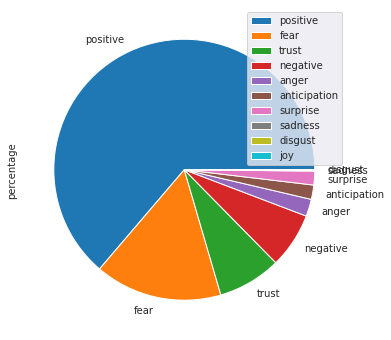

In [ ]:
plot = emotion_df.set_index('emotion').plot.pie(y='percentage', figsize=(10, 6))


Text(0.5, 1.0, 'Emotion Analysis- December Data')

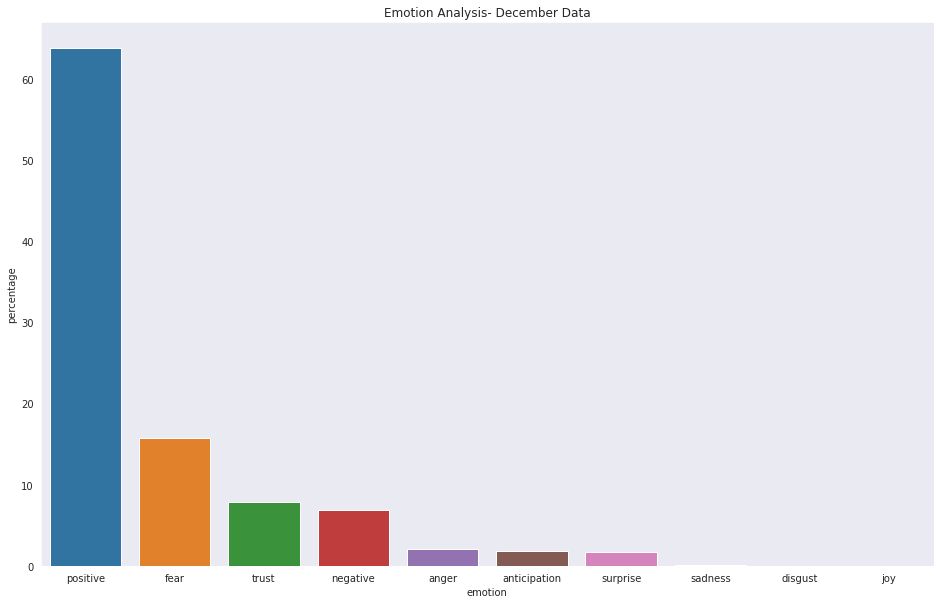

In [ ]:
# Plotting percentage of sentiments
plt.figure(figsize=(16,10))
ax = sns.barplot(x="emotion", y="percentage", data=emotion_df)
ax.set_title('Emotion Analysis- December Data')
